# Political Alignment and Other Views

This is the fourth in a series of notebooks that make up a [case study in exploratory data analysis](https://allendowney.github.io/PoliticalAlignmentCaseStudy/).
This case study is part of the [*Elements of Data Science*](https://allendowney.github.io/ElementsOfDataScience/) curriculum.
[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/PoliticalAlignmentCaseStudy/blob/v1/04_worlview.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/v1/utils.py")

This notebook is a template for a do-it-yourself, choose-your-own-adventure mini-project that explores the relationship between political alignment and other attitudes and beliefs.
I will outline the steps and provide sample code.
You can choose which survey question to explore, adapt my code for your data, and see what you discover.

In previous chapter, we looked at changes in political alignment over time, and explored the relationship between political alignment and survey questions related to "outlook".
The analysis in this notebook follows the steps we have seen:

1) For your variable of interest, you will compute and display the distribution (PMF) of responses and the distribution within each political group.

2) You will recode the variable on a numerical scale that makes it possible to interpret the mean, and then plot the mean over time.

3) You will use a pivot table to compute the mean of your variable over time for each political alignment group (liberal, moderate, and conservative).

4) Finally, you will look at results from three resamplings of the data to see whether the patterns you observed might be due to random sampling.

The following cell installs the `empiricaldist` library if necessary.

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

If everything we need is installed, the following cell should run without error.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

The following cells import functions from previous chapters we will use again.

In [4]:
from utils import values, decorate, make_lowess, plot_series_lowess, plot_columns_lowess

The following cells downloads the data file.

In [5]:
download(
    "https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/v1/gss_pacs_resampled.hdf"
)

Now we'll load the first resampled `DataFrame`.

In [6]:
datafile = "gss_pacs_resampled.hdf"
gss = pd.read_hdf(datafile, "gss0")
gss.shape

(72390, 207)

## Changes in social attitudes

The General Social Survey includes questions about a variety of social attitudes and beliefs.  We can use this dataset to explore changes in the responses over time and the relationship with political alignment.
In my subset of the GSS data, I selected questions that were asked repeatedly over the interval of the survey.

To follow the process demonstrated in this notebook, you should choose a variable that you think might be interesting.
If you are not sure which variable to explore, here is a random selection of three that you can choose from:

In [7]:
cols = list(gss.columns)
for col in ["id", "year", "ballot", "age", "sex", "race"]:
    cols.remove(col)

np.random.shuffle(cols)
for col in cols[:3]:
    print(col)

confinan
satfin
pikupsex


Fill in the name of the variable you chose below, and select a column.

The variable I'll use as an example is `homosex`, which contains responses to this question:

> What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

In [8]:
varname = "homosex"
column = gss[varname]
column.tail()

72385    4.0
72386    NaN
72387    1.0
72388    NaN
72389    NaN
Name: homosex, dtype: float64

As we'll see, response to this question have changed quickly over the last few decades.

## Responses

Here's the distribution of responses:

In [9]:
column.value_counts(dropna=False).sort_index()

1.0    24856
2.0     1857
3.0     2909
4.0    12956
5.0       94
NaN    29718
Name: homosex, dtype: int64

The following cell shows the numerical values and the text of the responses they stand for.

In [10]:
responses = [1, 2, 3, 4, 5]

labels = [
    "Always wrong",
    "Almost always wrong",
    "Sometimes wrong",
    "Not at all wrong",
    "Other",
]

Here's what the distribution looks like.
`plt.xticks` puts labels on the $x$-axis.

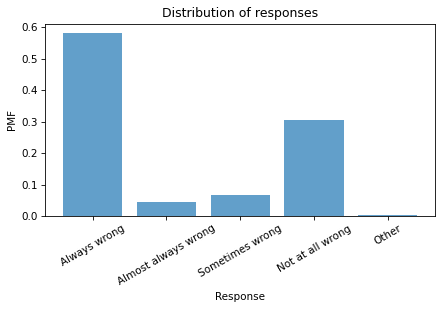

In [11]:
pmf = Pmf.from_seq(column)
pmf.bar(alpha=0.7)

decorate(xlabel="Response", ylabel="PMF", title="Distribution of responses")
plt.xticks(responses, labels, rotation=30);

A majority of respondents chose "Always wrong".
But remember that these results are an average over the entire interval of the survey, so you should not interpret it as a current condition.

## Responses over time

If we make a cross tabulation of `year` and the variable of interest, we get the distribution of responses over time.

In [12]:
xtab = pd.crosstab(gss["year"], column, normalize="index")
xtab.head()

homosex,1.0,2.0,3.0,4.0,5.0
year,,,,,
1973,0.724066,0.057400,0.082988,0.112725,0.022822
1974,0.709972,0.047051,0.073736,0.126404,0.042837
1976,0.679806,0.057400,0.089212,0.173582,0.000000
1977,0.729767,0.062414,0.071331,0.136488,0.000000
1980,0.725772,0.055994,0.058148,0.160086,0.000000


Now we can plot the results.

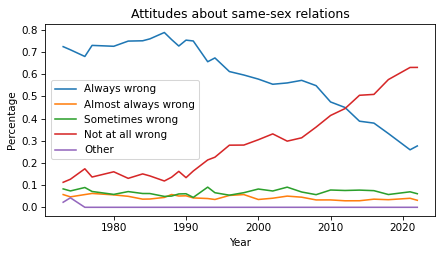

In [13]:
for response, label in zip(responses, labels):
    xtab[response].plot(label=label)

decorate(xlabel="Year", ylabel="Percentage", title="Attitudes about same-sex relations")

The fraction choosing "Always wrong" started to decline around 1990, and the fraction choosing "Not at all wrong" started to increase.
These lines crossed around 2010, and now "Not at all wrong" is the majority response.

## Political alignment

To explore the relationship between these responses and political alignment, we'll recode political alignment into three groups:

In [14]:
d_polviews = {
    1: "Liberal",
    2: "Liberal",
    3: "Liberal",
    4: "Moderate",
    5: "Conservative",
    6: "Conservative",
    7: "Conservative",
}

Now we can use `replace` and store the result as a new column in the `DataFrame`.

In [15]:
gss["polviews3"] = gss["polviews"].replace(d_polviews)

With this scale, there are roughly the same number of people in each group.

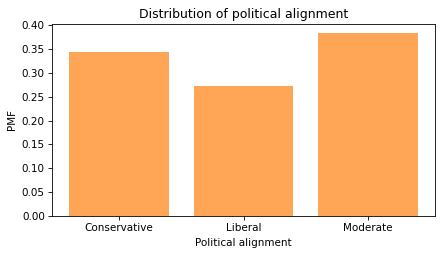

In [16]:
pmf = Pmf.from_seq(gss["polviews3"])
pmf.bar(color="C1", alpha=0.7)

decorate(
    xlabel="Political alignment",
    ylabel="PMF",
    title="Distribution of political alignment",
)

## Group by political alignment

Now we can use `groupby` to group the respondents by political alignment.

In [17]:
by_polviews = gss.groupby("polviews3")

Here's a dictionary that maps from each group to a color.

In [18]:
muted = sns.color_palette("muted", 5)
color_map = {"Conservative": muted[3], "Moderate": muted[4], "Liberal": muted[0]}

Now I'll make a PMF of responses for each group.

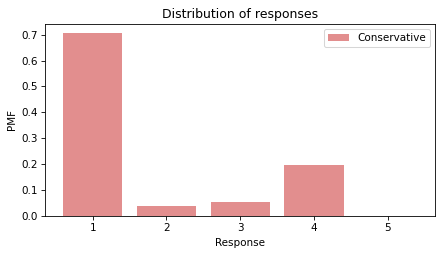

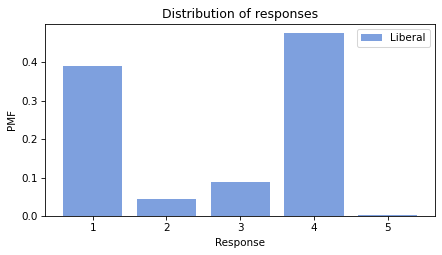

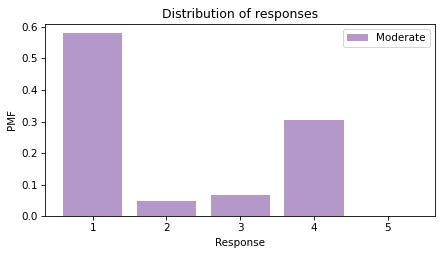

In [19]:
for name, group in by_polviews:
    plt.figure()
    pmf = Pmf.from_seq(group[varname])
    pmf.bar(label=name, color=color_map[name], alpha=0.7)

    decorate(xlabel="Response", ylabel="PMF", title="Distribution of responses")

But again, these results are an average over the interval of the survey, so you should not interpret them as a current condition.

## Recode

To quantify changes in these responses over time, one option is to put them on a numerical scale and compute the mean.
Another option is to compute the percentage who choose a particular response or set of responses.
Since the majority response is "Always wrong", that's the response we'll track.
We'll use `replace` to recode the values so "Always wrong" is `1` and all other responses are `0`.

In [20]:
d_recode = {1: 1, 2: 0, 3: 0, 4: 0, 5: 0}

gss["recoded"] = column.replace(d_recode)
gss["recoded"].name = varname

We can use `value_counts` to confirm that it worked.

In [21]:
gss["recoded"].value_counts(dropna=False)

NaN    29718
1.0    24856
0.0    17816
Name: homosex, dtype: int64

Now if we compute the mean, we can interpret it as "the fraction of respondents who think same-sex sexual relations are always wrong".
Multiplying by `100` makes it a percentage.

In [22]:
gss["recoded"].mean() * 100

58.24896887889014

Note that the `Series` method `mean` drops `NaN` values before computing the mean.
The NumPy function `mean` does not.

## Average by group

We can use `by_polviews` to compute the mean of the recoded variable in each group, and multiply by `100` to get a percentage.

In [23]:
means = by_polviews["recoded"].mean() * 100
means

polviews3
Conservative    70.661830
Liberal         38.934686
Moderate        58.118069
Name: homosex, dtype: float64

By default, the group names are in alphabetical order.
To get the values in a particular order, we can use the group names as an index:

In [24]:
groups = ["Conservative", "Moderate", "Liberal"]
means[groups]

polviews3
Conservative    70.661830
Moderate        58.118069
Liberal         38.934686
Name: homosex, dtype: float64

Now we can make a bar plot with color-coded bars:

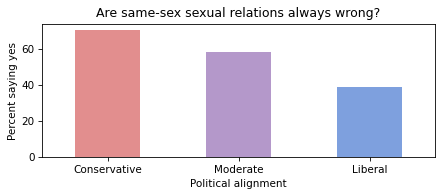

In [25]:
colors = color_map.values()
means[groups].plot(kind="bar", color=colors, alpha=0.7, label="")

decorate(
    xlabel="Political alignment",
    ylabel="Percent saying yes",
    title="Are same-sex sexual relations always wrong?",
)

plt.xticks(rotation=0);

As you might expect, more conservatives think homosexuality is "always wrong", compared to moderates and liberals.

## Time series

We can use `groupby` to group responses by year.

In [26]:
by_year = gss.groupby("year")

From the result we can select the recoded variable and compute the percentage that responded "Always wrong".

In [27]:
time_series = by_year["recoded"].mean() * 100

And we can plot the results with the data points themselves as circles and a local regression model as a line.

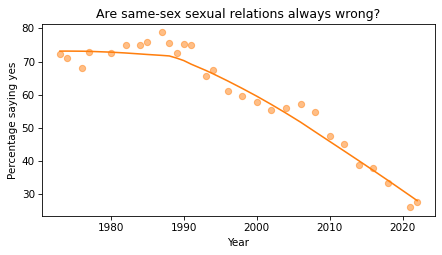

In [28]:
plot_series_lowess(time_series, "C1")

decorate(
    xlabel="Year",
    ylabel="Percentage saying yes",
    title="Are same-sex sexual relations always wrong?",
    legend=False
)

The fraction of respondents who think homosexuality is wrong has fallen steeply since about 1990.

## Time series by group

So far, we have grouped by `polviews3` and computed the mean of the variable of interest in each group.
Then we grouped by `year` and computed the mean for each year.
Now we'll use `pivot_table` to compute the mean in each group for each year.

In [29]:
table = gss.pivot_table(
    values="recoded", index="year", columns="polviews3", aggfunc="mean"
)

In [30]:
table.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1974,0.795620,0.546512,0.767892
1976,0.775000,0.489848,0.716698
1977,0.823666,0.564165,0.769772
1980,0.834906,0.539130,0.740171
1982,0.801126,0.599198,0.811820


The result is a table that has years running down the rows and political alignment running across the columns.

Each entry in the table is the mean of the variable of interest for a given group in a given year.

## Plotting the results

Now let's see the results.

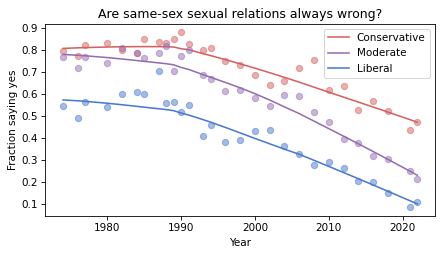

In [31]:
for group in groups:
    series = table[group]
    plot_series_lowess(series, color_map[group])
    
decorate(
    xlabel="Year",
    ylabel="Fraction saying yes",
    title="Are same-sex sexual relations always wrong?",
)

Negative attitudes about homosexuality declined in all three groups, starting at about the same time, and at almost the same rate.

## Resampling

The figures we have generated so far in this notebook are based on a single resampling of the GSS data.  Some of the features we see in these figures might be due to random sampling rather than actual changes in the world.
By generating the same figures with different resampled datasets, we can get a sense of how much variation there is due to random sampling.
To make that easier, the following function contains the code from the previous analysis all in one place.

In [32]:
def plot_by_polviews(gss, varname):
    """Plot mean response by polviews and year.

    gss: DataFrame
    varname: string column name
    """
    gss["polviews3"] = gss["polviews"].replace(d_polviews)

    column = gss[varname]
    gss["recoded"] = column.replace(d_recode)

    table = gss.pivot_table(
        values="recoded", index="year", columns="polviews3", aggfunc="mean"
    )

    for group in groups:
        series = table[group]
        plot_series_lowess(series, color_map[group])

    decorate(
        xlabel="Year",
        ylabel="Fraction saying yes",
        title="Are same-sex relations always wrong?",
    )

Now we can loop through the three resampled datasets and generate a figure for each one.

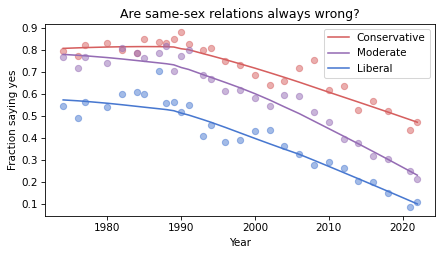

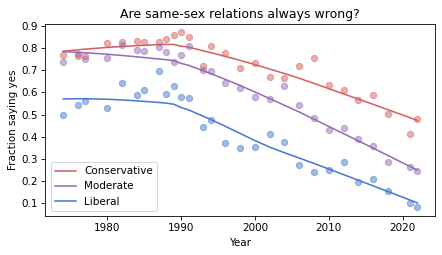

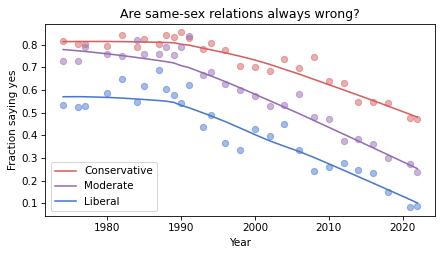

In [33]:
datafile = "gss_pacs_resampled.hdf"

for key in ["gss0", "gss1", "gss2"]:
    df = pd.read_hdf(datafile, key)

    plt.figure()
    plot_by_polviews(df, varname)

If you see an effect that is consistent in all three figures, it is less likely to be due to random sampling.
If it varies from one resampling to the next, you should probably not take it too seriously.

Political Alignment Case Study

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)